# Data Gathering

We will start by getting the data from the 'fashion_dataset' directory.

In [1]:
!wget https://github.com/mohamed-12-4/DSAI--COSC-202-/raw/refs/heads/master/fashion_dataset.zip
!unzip fashion_dataset

Streaming output truncated to the last 5000 lines.
  inflating: fashion_dataset/9/18732.png  
  inflating: fashion_dataset/9/18739.png  
  inflating: fashion_dataset/9/18744.png  
  inflating: fashion_dataset/9/18746.png  
  inflating: fashion_dataset/9/18756.png  
  inflating: fashion_dataset/9/18770.png  
  inflating: fashion_dataset/9/18795.png  
  inflating: fashion_dataset/9/18806.png  
  inflating: fashion_dataset/9/18819.png  
  inflating: fashion_dataset/9/18836.png  
  inflating: fashion_dataset/9/18843.png  
  inflating: fashion_dataset/9/18857.png  
  inflating: fashion_dataset/9/1889.png  
  inflating: fashion_dataset/9/18892.png  
  inflating: fashion_dataset/9/18899.png  
  inflating: fashion_dataset/9/18902.png  
  inflating: fashion_dataset/9/18931.png  
  inflating: fashion_dataset/9/18941.png  
  inflating: fashion_dataset/9/18954.png  
  inflating: fashion_dataset/9/18955.png  
  inflating: fashion_dataset/9/18969.png  
  inflating: fashion_dataset/9/18973.png  
  in

In [2]:
import os
import glob
import pandas as pd
import cv2
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def load_data(path: str) -> pd.DataFrame:
    """
    Load the data from the path and return a pandas dataframe with the images path and labels.
    param path: str: path to the images directory
    """
    images = []
    labels = []
    for image_path in glob.glob(path + '/*/*.png'):
        images.append(image_path)
        labels.append(image_path.split('/')[-2])

    images_df = pd.DataFrame({'images_path': images, 'labels': labels})
    return images_df



In [4]:
images_df = load_data('./fashion_dataset')

In [5]:
images_df

,images_path,labels
0,./fashion_dataset/1/25497.png,1
1,./fashion_dataset/1/37776.png,1
2,./fashion_dataset/1/50849.png,1
3,./fashion_dataset/1/24607.png,1
4,./fashion_dataset/1/38196.png,1
...,...,...
59995,./fashion_dataset/6/37961.png,6
59996,./fashion_dataset/6/21287.png,6
59997,./fashion_dataset/6/17892.png,6
59998,./fashion_dataset/6/3336.png,6


In [6]:
images_df.labels.value_counts()
images_df.labels = images_df.labels.astype(int)

In [7]:
images_df

,images_path,labels
0,./fashion_dataset/1/25497.png,1
1,./fashion_dataset/1/37776.png,1
2,./fashion_dataset/1/50849.png,1
3,./fashion_dataset/1/24607.png,1
4,./fashion_dataset/1/38196.png,1
...,...,...
59995,./fashion_dataset/6/37961.png,6
59996,./fashion_dataset/6/21287.png,6
59997,./fashion_dataset/6/17892.png,6
59998,./fashion_dataset/6/3336.png,6


In [8]:
labels_map = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

def class_to_name(label) -> str:
    """
    Convert the label to the name of the class
    param label: int: label of the class
    """

    return labels_map[label]

Sneaker


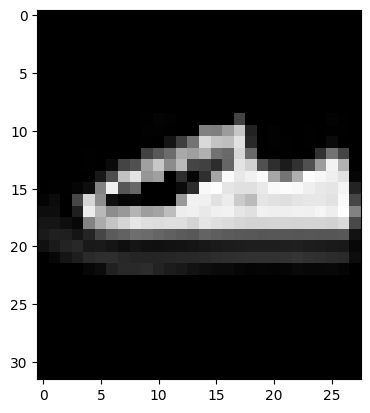

In [9]:
def view_image(path: str):
    """
    View the image from the path
    param path: str: path to the image
    """
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    img = cv2.imread(path)
    plt.imshow(img)

index = random.randint(0, len(images_df))
image_path = images_df.images_path[index]
label = images_df.labels[index]
print(class_to_name(label))
view_image(image_path)


<Axes: ylabel='count'>

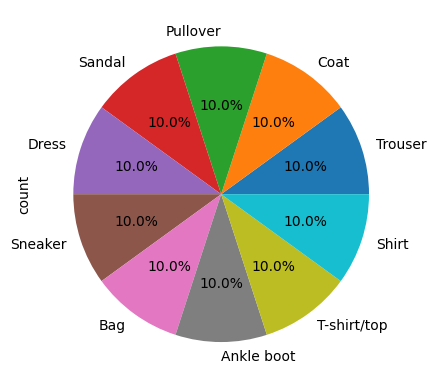

In [10]:
# plot a pie plot of the classes
images_df['class_name'] = images_df['labels'].apply(class_to_name)

images_df.class_name.value_counts().plot(kind='pie', autopct='%1.1f%%', )

# Trying different models

In [11]:
def create_dataset(df: pd.DataFrame, batch_size: int):
    """
    Create the dataset from the dataframe
    param df: pd.DataFrame: dataframe with the images path and labels
    """
    imagegen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.)
    dataset = imagegen.flow_from_dataframe(
        df,
        x_col='images_path',
        y_col='labels',
        target_size=(28, 28),
        class_mode='raw',
        batch_size=batch_size,
    )
    return dataset



In [12]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(images_df, test_size=0.2, random_state=42)
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=42)

In [13]:
dataset = create_dataset(images_df, 64)
train_dataset = create_dataset(train_df, 64)
test_dataset = create_dataset(test_df, 64)
val_dataset = create_dataset(val_df, 64)

Found 60000 validated image filenames.
Found 48000 validated image filenames.
Found 6000 validated image filenames.
Found 6000 validated image filenames.


In [14]:
len(dataset)

938

In [15]:
dataset[0][1]

array([5, 7, 3, 8, 5, 7, 9, 2, 0, 1, 4, 2, 7, 4, 3, 6, 3, 2, 7, 2, 1, 9,
       3, 4, 6, 6, 1, 2, 4, 4, 1, 0, 2, 1, 4, 3, 8, 1, 3, 0, 8, 6, 0, 0,
       5, 3, 4, 8, 4, 9, 9, 2, 5, 5, 8, 8, 2, 7, 3, 1, 9, 3, 9, 6])

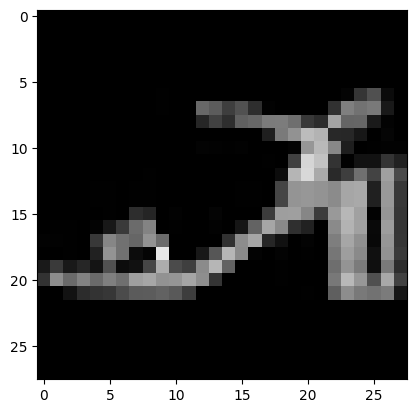

In [16]:
plt.imshow(dataset[0][0][0])

# Simple NN (Only dense layers)

In [17]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

# Convolutional NN

In [18]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 22, 22, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │       1,982,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,039,498 (7.78 MB)

 Trainable params: 2,039,498 (7.78 MB)

 Non-trainable params: 0 (0.00 B)

# Convolutional NN w/MaxPooling layers

In [19]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 26, 26, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 3, 3, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,898 (366.79 KB)

 Trainable params: 93,898 (366.79 KB)

 Non-trainable params: 0 (0.00 B)

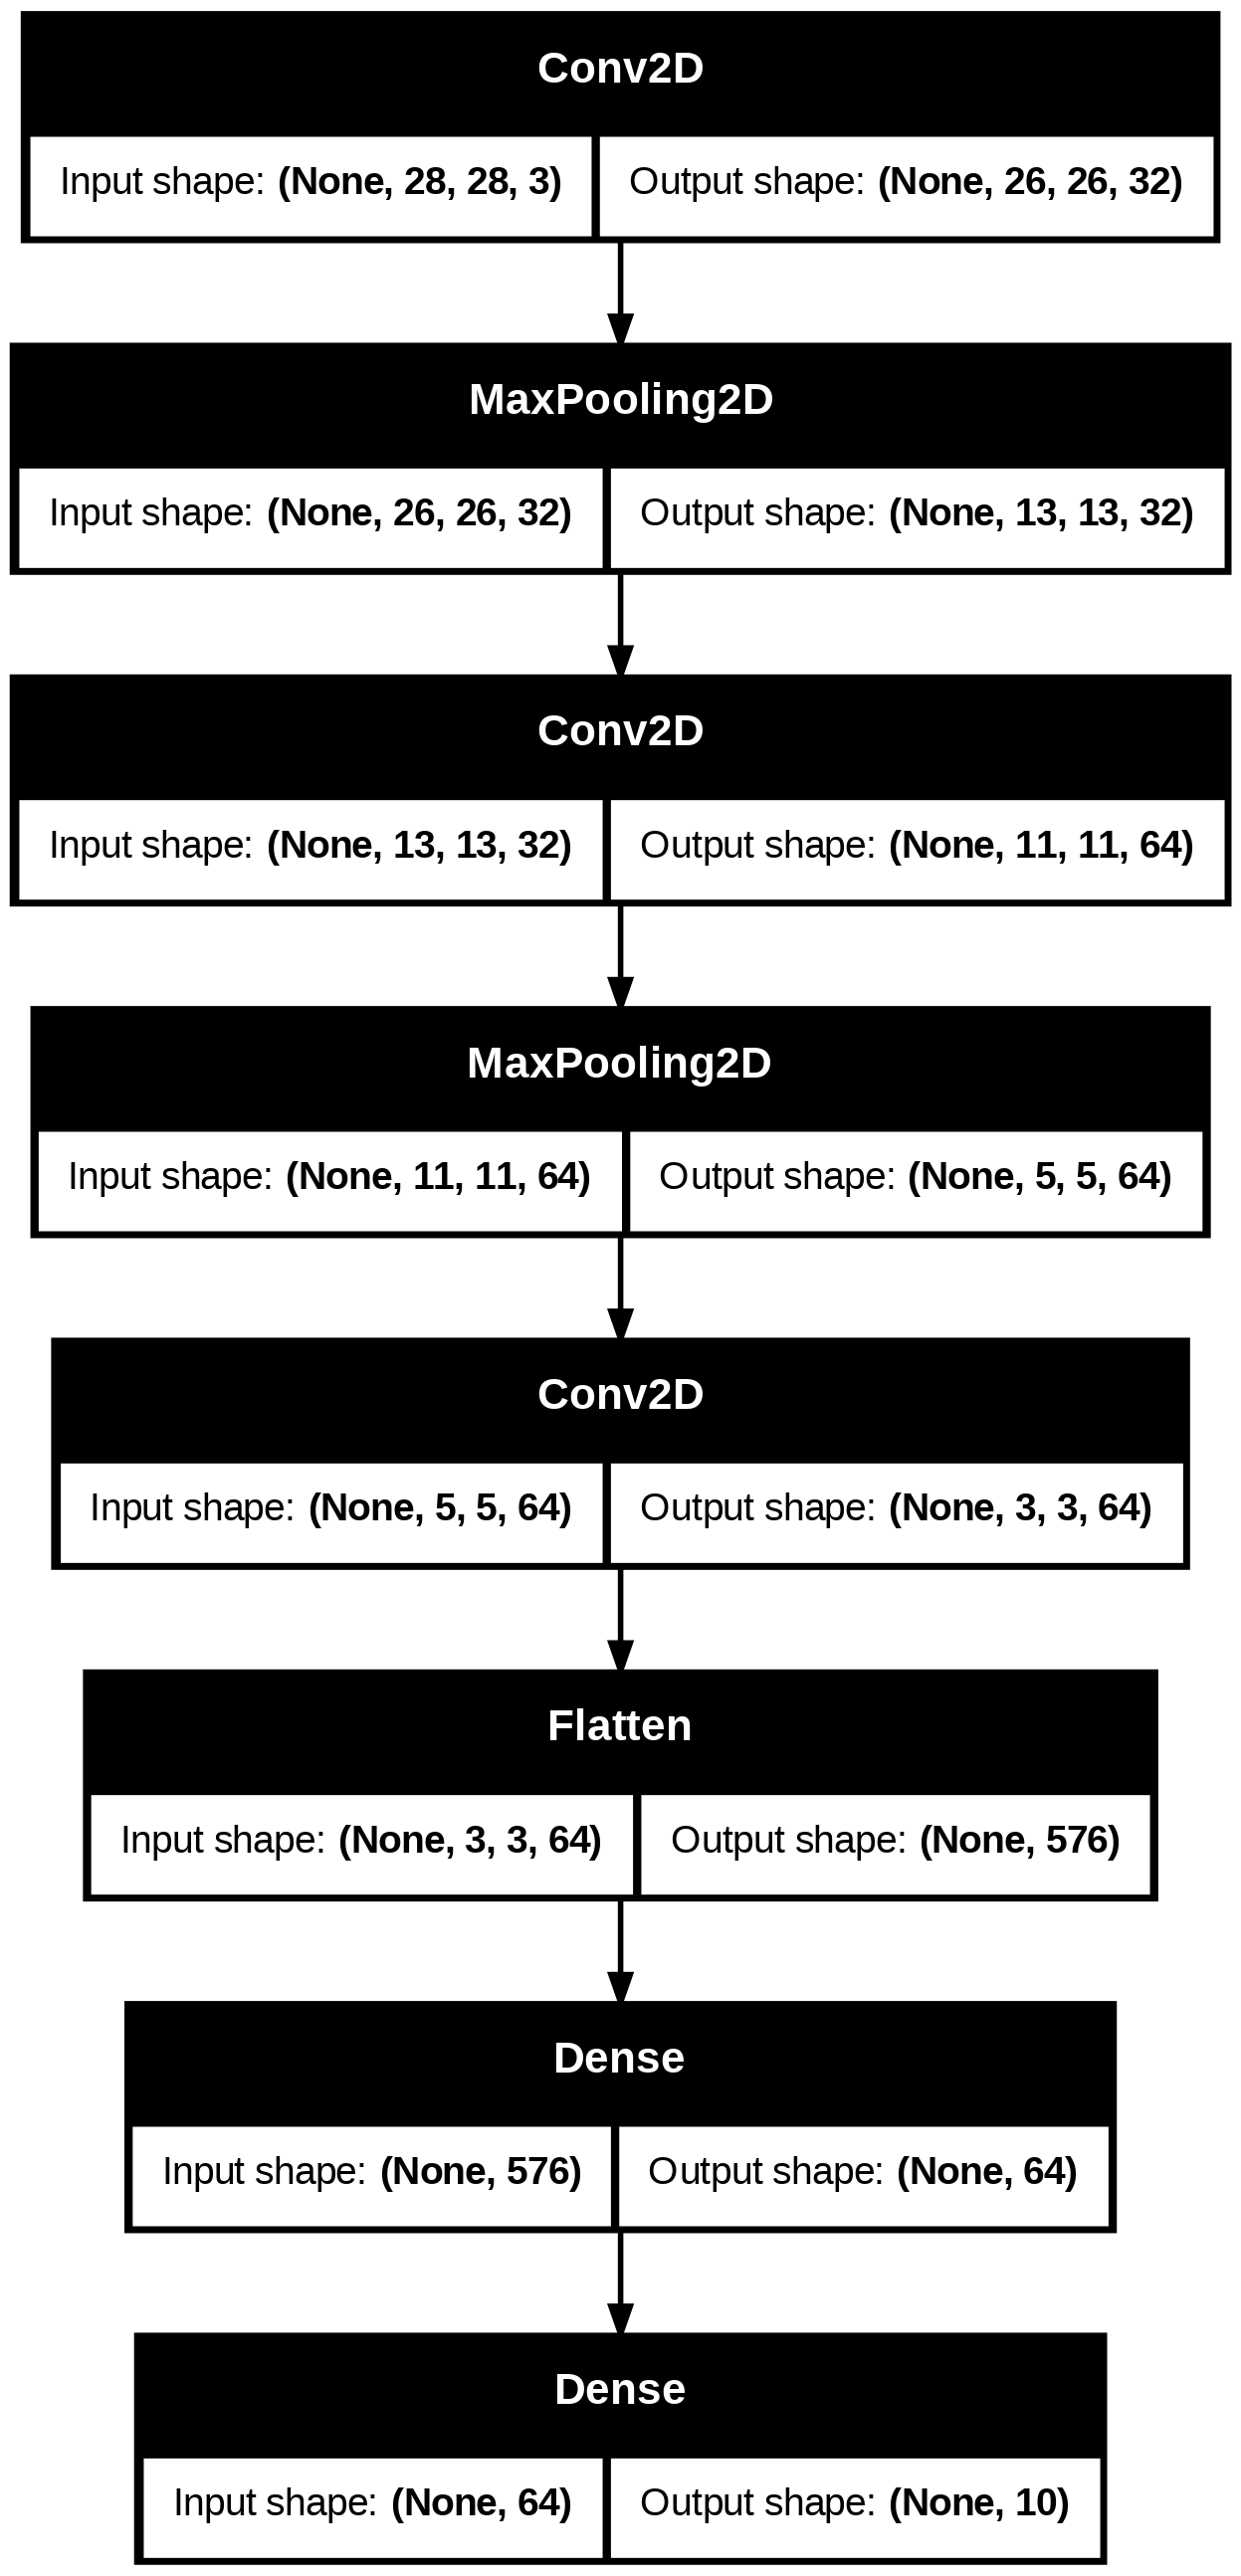

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [22]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_dataset, epochs=100, callbacks=[callback], validation_data=val_dataset)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7877 - loss: 0.5680

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


750/750 ━━━━━━━━━━━━━━━━━━━━ 64s 82ms/step - accuracy: 0.7877 - loss: 0.5679 - val_accuracy: 0.8538 - val_loss: 0.3979
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 61s 82ms/step - accuracy: 0.8714 - loss: 0.3546 - val_accuracy: 0.8858 - val_loss: 0.3198
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 80s 79ms/step - accuracy: 0.8905 - loss: 0.3016 - val_accuracy: 0.8880 - val_loss: 0.3059
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 59s 79ms/step - accuracy: 0.9028 - loss: 0.2646 - val_accuracy: 0.8965 - val_loss: 0.2896
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 59s 78ms/step - accuracy: 0.9101 - loss: 0.2471 - val_accuracy: 0.8998 - val_loss: 0.2787
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 60s 80ms/step - accuracy: 0.9192 - loss: 0.2217 - val_accuracy: 0.8985 - val_loss: 0.2874
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 86s 86ms/step - accuracy: 0.9250 - loss: 0.2012 - val_accuracy: 0.9028 - val_loss: 0.2728
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 77s 79ms/step - accuracy: 0.9331 - loss: 0.1837 - val_

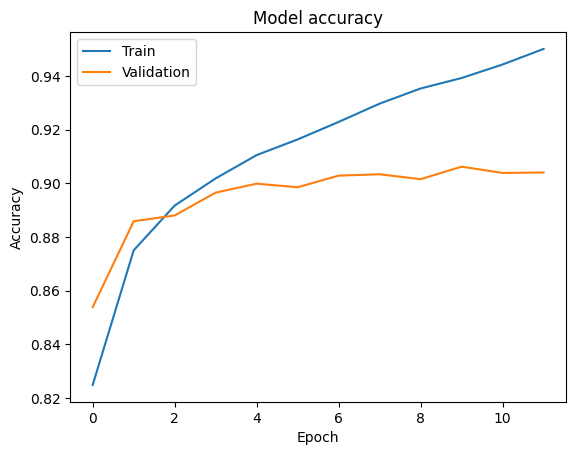

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [27]:
pred = model.predict(test_dataset)

94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step


In [28]:
test = test_df[0:10]

In [29]:
test

,images_path,labels,class_name
59075,./fashion_dataset/6/38529.png,6,Shirt
2767,./fashion_dataset/1/41565.png,1,Trouser
10434,./fashion_dataset/4/1648.png,4,Coat
59295,./fashion_dataset/6/29969.png,6,Shirt
59668,./fashion_dataset/6/44913.png,6,Shirt
35364,./fashion_dataset/7/4111.png,7,Sneaker
49092,./fashion_dataset/0/37250.png,0,T-shirt/top
51711,./fashion_dataset/0/8141.png,0,T-shirt/top
22653,./fashion_dataset/5/12995.png,5,Sandal
28895,./fashion_dataset/3/32438.png,3,Dress


In [30]:
for (img, label) in zip(test.images_path, test.labels):
    img = cv2.imread(img)
    img = cv2.resize(img, (28, 28))
    img = np.array(img)
    img = img.reshape(1, 28, 28, 3)
    model.predict(img)
    print(class_to_name(label), class_to_name(np.argmax(model.predict(img))))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Shirt Shirt
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Trouser Trouser
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Coat Coat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Shirt Shirt
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Shirt Shirt
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Sneaker Sneaker
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
T-shirt/top T-shirt/top
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
T-shirt/top Shirt
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Sandal Sandal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Dress Dress


In [31]:
test_dataset[0][1][0]

9

In [32]:
np.argmax(pred)

221

In [33]:
model.evaluate(test_dataset)

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9121 - loss: 0.2603


[0.260837584733963, 0.9066666960716248]

In [26]:
import pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
model